In [2]:
%matplotlib inline
import math as math
import numpy as np
from scipy import integrate, linalg, special
import matplotlib.pyplot as plt

# Caputo derivative

$$\partial_t^\alpha u = \frac{1}{\Gamma(1-\alpha)}\int^t_0 \frac{\partial_s u}{(t-u)^\alpha}\,ds$$

# Numerical schemes

## Second order BDF method

For $n\ge 1$, the derivative is computed by

$$
D_c^{\gamma}u(t^{n+1})\approx
k^{-\gamma}(b^{n+1}*u)_{n+1}=:\mathcal{D}_k u.
$$

Here $b^{n+1}=(b_m^{n+1})_{m=0}^{n+1}$ is a sequence with $n+2$ components.

$$
(b^{n+1}*u)_{n+1}=\sum_{m=0}^{n+1}b_{m}^{n+1}u_{n+1-m}
$$

is the $n+1$-th component of this convolution.

The sequences $b^{n+1}$ are given as follows:

For $n=1$,
\begin{gather*}
\Gamma(2-\gamma)b_{0}^{2}=-\frac{1}{2}2^{1-\gamma}+\frac{1}{2-\gamma}2^{2-\gamma}\\
\Gamma(2-\gamma)b_{1}^{2}=2\cdot 2^{1-\gamma}-\frac{2}{2-\gamma}2^{2-\gamma}\\
\Gamma(2-\gamma)b_{2}^{2}=-\frac{3}{2}2^{1-\gamma}+\frac{1}{2-\gamma}2^{2-\gamma}
\end{gather*}

For $n=2$,
\begin{gather*}
\Gamma(2-\gamma)b_{0}^{3}=\frac{1}{2}+\frac{1}{2-\gamma}\\
\Gamma(2-\gamma)b_{1}^{3}
=-\frac{3}{2}-\frac{3}{2-\gamma}-\frac{1}{2}3^{1-\gamma}
+\frac{1}{2-\gamma}3^{2-\gamma}\\
\Gamma(2-\gamma)b_{2}^{3}=\frac{3}{2}+2\cdot 3^{1-\gamma}
+\frac{3}{2-\gamma}-\frac{2}{2-\gamma}3^{2-\gamma}\\
\Gamma(2-\gamma)b_{3}^{3}=-\frac{1}{2}
-\frac{3}{2}3^{1-\gamma}+\frac{1}{2-\gamma}(3^{2-\gamma}-1)
\end{gather*}

For $n\ge 3$:

\begin{gather}
\begin{array}{c}
\Gamma(2-\gamma)b_{0}^{n+1}=\frac{1}{2}+\frac{1}{2-\gamma},\\
\Gamma(2-\gamma)b_1^{n+1}=-\frac{3}{2}+2^{1-\gamma}\frac{1}{2}
-\frac{3}{2-\gamma}+\frac{1}{2-\gamma}2^{2-\gamma}
 \end{array}
\end{gather}

When $2\le m\le n-2$, we have $\Gamma(2-\gamma)b_{m}^{n+1}=h(m)$ where the function $h$ is given by

\begin{multline}
h(m)=-\frac{1}{2}(m-2)^{1-\gamma}-\frac{3}{2}m^{1-\gamma}+\frac{3}{2}(m-1)^{1-\gamma}+\frac{1}{2}(m+1)^{1-\gamma}\\
+\frac{1}{2-\gamma}(m+1)^{2-\gamma}
-\frac{3}{2-\gamma}m^{2-\gamma}
+\frac{3}{2-\gamma}(m-1)^{2-\gamma}
-\frac{1}{2-\gamma}(m-2)^{2-\gamma}
\end{multline}

For the last three coefficients,

\begin{gather}
\Gamma(2-\gamma)b_{n-1}^{n+1}
=-\frac{1}{2}n^{1-\gamma}-\frac{1}{2}(n+1)^{1-\gamma}
-\frac{1}{2-\gamma}[n^{2-\gamma}-(n+1)^{2-\gamma}]
+h(n-1)\\
\Gamma(2-\gamma)b_n^{n+1}=h(n)+\frac{3}{2}n^{1-\gamma}+\frac{3}{2}(n+1)^{1-\gamma}
+\frac{3}{2-\gamma}[n^{2-\gamma}-(n+1)^{2-\gamma}]\\
\Gamma(2-\gamma)b_{n+1}^{n+1}
=-\frac{1}{2}(n-1)^{1-\gamma}-\frac{3}{2}(n+1)^{1-\gamma}
-\frac{1}{2-\gamma}(n-1)^{2-\gamma}+\frac{1}{2-\gamma}(n+1)^{2-\gamma}
\end{gather}

In [2]:
class CaputoDerivative:
    '''Discretization of Caputo derivative with finite difference method
    
    Attributes:
    -----------
    gamma: float 
           differential order, fractional
    dt: float
        time step
    nt: float
        total time steps
        
    Methods:
    ---------
    bdf2_set: set up the coefficients b (1D array of floats) of bdf2
    bdf2_l: coefficient of local part
    bdf2_h: history part of the derivative

    '''
    
    def __init__(self, gamma, dt, nt):
        self.gamma = gamma
        self.dt = dt
        self.nt = nt        
        
    def bdf2_set(self):
        nt, g_1, g_2 = self.nt, 1-self.gamma, 2-self.gamma
        h = lambda m: -0.5*(m-2)**g_1 - 1.5*m**g_1 + 1.5*(m-1)**g_1 + 0.5*(m+1)**g_1 + ((m+1)**g_2 - 3*m**g_2 + 3*(m-1)**g_2
                      -(m-2)**g_2)/g_2
        self.b = np.zeros(nt-2)
        self.b[0] = 0.5 + 1/g_2
        self.b[1] = -1.5 + 2**g_1/2 - 3/g_2 + 2**g_2/g_2
        self.b[2:] = h(np.arange(2, nt-2))
        lnt = np.arange(3,nt)
        self.b2 = -0.5*lnt**g_1 - 0.5*(lnt+1)**g_1 - (lnt**g_2 - (lnt+1)**g_2)/g_2 + h(lnt-1)
        self.b1 = h(lnt) + 1.5*lnt**g_1 + 1.5*(lnt+1)**g_1 + 3*(lnt**g_2 - (lnt+1)**g_2)/g_2
        self.b0 = -0.5*(lnt-1)**g_1 - 1.5*(lnt+1)**g_1 - (lnt-1)**g_2/g_2 + (lnt+1)**g_2/g_2
        
    def bdf2_l(self):
        return self.b[0]/(special.gamma(2-self.gamma)*self.dt**self.gamma)
        
    def bdf2_h(self, u, n):
        b_n = np.zeros(n+1)
        b_n[3:] = self.b[n-2:0:-1]
        b_n[2] = self.b2[n-3]
        b_n[1] = self.b1[n-3]
        b_n[0] = self.b0[n-3]
        
        return b_n @ (u[:n+1])/(special.gamma(2-self.gamma)*self.dt**self.gamma)

In [3]:
gamma = 0.99999999999
T = 3
nt = 3
dt = T/nt
u = np.zeros(nt+1)
u = np.exp(2*np.arange(nt+1)*dt)
Dt_u = CaputoDerivative(gamma, dt, nt+1)
Dt_u.bdf2_set()
Dt_u.bdf2_h(u, nt-1) + Dt_u.bdf2_l()*u[nt] 

632.44226525454428

In [4]:
def E(z, a, b, N):
    n = np.arange(N)
    return np.sum(z**n/special.gamma(a*n+b))

In [5]:
2*np.exp(2)

14.778112197861301

In [7]:
def preconditioner(s, M):
    return s/M

In [8]:
def pcg(p, elliptic, M, s, dx, dy, dt, l2_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p: 2D array of floats
       Initial guess
    b: 2D array of floats
       Source term
    A: a function with 2D array of floats as input
       elliptic operator
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    res = np.zeros((ny,nx)) # residual
    ellip_d  = np.zeros((ny,nx)) # to store result of matrix multiplication 
    precond_res = np.zeros((ny,nx))
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    res = s - elliptic(p, dx, dy)
    precond_res = preconditioner(res.copy(), M)
    d = precond_res.copy()
    tmp = np.sum(res*precond_res)
    ellip_d = elliptic(d, dx, dy)
    sigma = np.sum(d*ellip_d)
    
    # Iterations
    while l2_norm > l2_target:

        p_k = p.copy()
        res_k = res.copy()
        d_k = d.copy()
        
        alpha = tmp/sigma

        p = p_k + alpha*d_k
        res = res_k - alpha*ellip_d
        
        precond_res = preconditioner(res.copy(), M)
        tmp_p1 = np.sum(precond_res*res)
        beta = tmp_p1/tmp
        tmp = tmp_p1
        
        d = precond_res + beta*d_k
        ellip_d = elliptic(d, dx, dy)
        sigma = np.sum(d*ellip_d)
        
        l2_norm = L2_rel_error(p_k,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of PCG iterations: {0:d}'.format(iterations))
    return p, l2_conv     

In [9]:
class KellerSegal:
    def __init__(self, rho, c, gamma, dt, nt, dx, nx):
        self.rho = np.zeros((nt,nx,nx))
        self.c = np.zeros((nx,nx))
        self.gamma = gamma
        self.dt = dt
        self.dx = dx
        self.nt = nt
        self.Dt_rho = CaputoDerivative(gamma, dt, nt)
        
    def laplace_set(self):
        nx, dx = self.nx, self,dx
        self.lambda_ = 4*((np.sin(np.arange(0,nx)*np.pi/nx)**2)[:,None] 
                        + (np.sin(np.arange(0,nx)*np.pi/nx)**2)[None,:])/dx**2
        self.lambda_[0,0] = 1
    
    def concentration_march(self, n):
        rho_hat = np.fft.fft2(rho[n])
        rho_hat[0,0] = 0
        self.c = np.fft.ifft2(rho_hat/lambda_)
        
    def fokker_planck(self, p, dx, dy):
        M_sqr = np.exp(0.5*self.c)
        M_sqm = np.roll(M_sqr,1,axis=0) + np.roll(M_sqr,-1,axis=0) + np.roll(M_sqr,1,axis=1) + np.roll(M_sqr,-1,axis=1)
        h = p/M_sqr
        S = (np.roll(h,1,axis=0) + np.roll(h,-1,axis=0) 
             + np.roll(h,1,axis=1) + np.roll(h,-1,axis=1))/dx**2
        self.M = self.Dt_rho.bdf2_l()*p + M_sqm*p/M_sqr**2/dx**2
        return self.M - S
    
    def density_march(self, n):
        his = -Dt_rho.bdf2_h(self.rho, n)
        p = self.rho[n]
        self.rho[n+1] = pcg(p, self.fokker_planck, self.M, his, self.nx, self.nx, self.dt, 10e-6)
        
    def solve(self):
        self.Dt_rho.bdf2_set()
        self.laplace_set()
        for n in np.arange(self.nt-1):
            self.concentration_march()
            self.density_march()
            

In [10]:
K = KellerSegal()

TypeError: __init__() missing 7 required positional arguments: 'rho', 'c', 'gamma', 'dt', 'nt', 'dx', and 'nx'

In [16]:
# Set up parameters.
dx = 0.01
x = np.arange(-2,2,dx)
nx = x.shape[0]
dt = 0.001
nt = 200
T = dt*nt
alpha = 0.8
a = 1
uL = 2
uR = 1

# Set up initial data
u = np.zeros((nt, nx))
#u[0] = ((x < -1)*uL + (x > 1)*uR)*np.ones(nx) + (x > -1)*(x < 1)*(0.5*np.sin(3/2*np.pi*x) + 1.5)
u[0] = ((x < 0)*uL + (x > 0)*uR)*np.ones(nx)
# Iteration of the scheme

# Generate the coefficient matrix A
d1 = -special.gamma(2-alpha)*dt**(alpha)/dx*a*np.ones(nx-1)
d = 1 + special.gamma(2-alpha)*dt**(alpha)/dx*a*np.ones(nx)
A = np.diagflat(d1,1) + np.diagflat(d)
#A[0, 0] = 1
invA = linalg.inv(A)

# Generate the source term b
q = np.zeros(nx)
q[0] = special.gamma(2-alpha)*dt**(alpha)/dx*a*uL


u[1] = (u[0] + q[None,:]).dot(invA)
for n in np.arange(1,3):
    u[n+1] = (u[n] - (np.arange(n+1,1,-1)**(1-alpha) - np.arange(n,0,-1)**(1-alpha)).dot(u[1:n+1] - u[:n]) + q[None,:]).dot(invA)


In [17]:
gamma = alpha
g_1 = 1 - gamma
g_2 = 2 - gamma

Dt_u = CaputoDerivative(gamma, dt, nt)
Dt_u.bdf2_set()

d1 = -np.ones(nx-1)/dx
d = Dt_u.bdf2_l() + np.ones(nx)/dx
A = np.diagflat(d1,1) + np.diagflat(d)
        #A[0, 0] = 1
invA = linalg.inv(A)
        
s = np.zeros(nx)
s[0] = 2/dx
        
for n in np.arange(3, nt-1):
    u[n+1] = (s[None, :] - Dt_u.bdf2_h(u, n)).dot(invA)

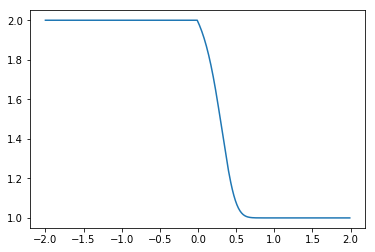

In [18]:
plt.plot(x, u[-1])

In [175]:
a = np.arange(5)

In [184]:
a

array([0, 1, 2, 3, 4])

In [186]:
a[1:7:3]

array([1, 4])

In [187]:
np.roll(a,1)

array([4, 0, 1, 2, 3])